In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 39.8 MB/s eta 0:00:0000:0100:01


In [55]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [56]:
df = pd.read_excel('/kaggle/input/atomic-hack/35000.xlsx')

In [57]:
from rdkit.Chem import Descriptors

def extract_features(smiles_str):
    mol = Chem.MolFromSmiles(smiles_str)
    if mol is None:  # Check if the molecule is valid
        return None

    features = {
        "Molecular_Weight": Descriptors.MolWt(mol),
        "Num_Atoms": mol.GetNumAtoms(),
        "Num_Bonds": mol.GetNumBonds(),
        "Num_RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "Num_AromaticAtoms": sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic()),
        "Num_AromaticRings": Descriptors.NumAromaticRings(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "Num_HeavyAtoms": Descriptors.HeavyAtomCount(mol),
        "Num_Heteroatoms": Descriptors.NumHeteroatoms(mol),
        "Num_Nitrogens": Descriptors.NumValenceElectrons(mol) - Descriptors.NumValenceElectrons(Chem.RemoveHs(mol)),
        # "Num_Oxygens": Descriptors.NumOxygens(mol),
        "Num_Rings": Descriptors.RingCount(mol),
        "Num_SaturatedRings": Descriptors.NumSaturatedRings(mol),
        "Num_sp3Carbons": Descriptors.NumAliphaticCarbocycles(mol),
        "Fraction_sp3Carbons": Descriptors.FractionCSP3(mol),
        "Num_AliphaticRings": Descriptors.NumAliphaticRings(mol),
        "Num_ValenceElectrons": Descriptors.NumValenceElectrons(mol),
        # "Num_Heterocycles": Descriptors.NumHeterocycles(mol)
    }
    
    return features


In [58]:
df_features = df['SMILES'].apply(extract_features).apply(pd.Series)

# Merge the extracted features with the original DataFrame
df_extended = pd.concat([df, df_features], axis=1)

[08:50:53] Conflicting single bond directions around double bond at index 55.
[08:50:53]   BondStereo set to STEREONONE and single bond directions set to NONE.
[08:52:51] Conflicting single bond directions around double bond at index 7.
[08:52:51]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [7]:
df.describe()

,Unnamed: 0,IC50
count,0.0,36377.000000
mean,NaN,7.813503
std,NaN,48.489710
min,NaN,0.000010
25%,NaN,1.696000
50%,NaN,3.635000
75%,NaN,5.934000
max,NaN,3183.600000


In [8]:
df_extended['S_leng'] = df_extended['SMILES'].str.len ()
df_extended = df_extended[df_extended.S_leng <= 150]

In [59]:
df_w = df_extended[['IC50', 'SMILES', 'Molecular_Weight', 'Num_RotatableBonds',
       'Num_AromaticAtoms', 'LogP', 'TPSA', 'Num_Heteroatoms', 'Num_Nitrogens',
       'Num_Rings', 'Num_SaturatedRings', 'Num_sp3Carbons',
       'Fraction_sp3Carbons', 'Num_AliphaticRings']]

In [60]:
quantile_97 = df_w['IC50'].quantile(0.97)
df_w = df_w[df_w['IC50'] <= quantile_97]

## Анализ данных

<Axes: xlabel='IC50', ylabel='Count'>

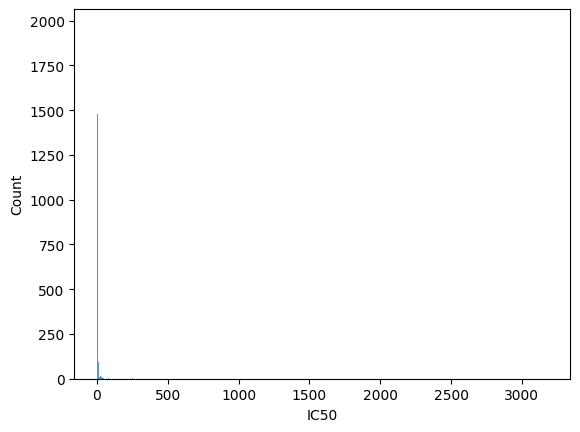

In [61]:
sns.histplot(df['IC50'])

<Axes: xlabel='IC50', ylabel='Count'>

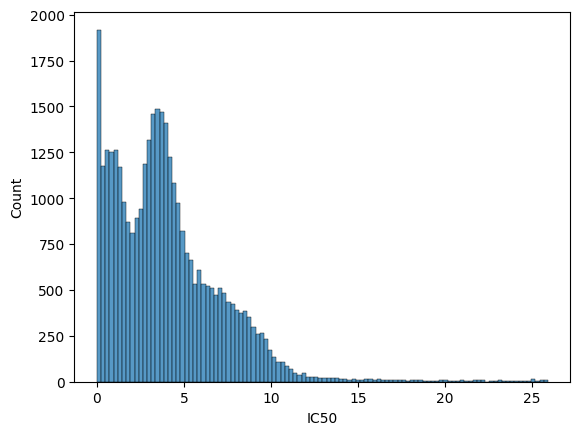

In [62]:
sns.histplot(df_w['IC50'])

## Векторайзер

OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2

In [63]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

[09:00:12] Conflicting single bond directions around double bond at index 55.
[09:00:12]   BondStereo set to STEREONONE and single bond directions set to NONE.


,SMILES,Molecule
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,<rdkit.Chem.rdchem.Mol object at 0x7f499c806ea0>
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,<rdkit.Chem.rdchem.Mol object at 0x7f499c806b90>
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,<rdkit.Chem.rdchem.Mol object at 0x7f499c806f10>
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7f499c806f80>
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,<rdkit.Chem.rdchem.Mol object at 0x7f499c806880>
...,...,...
35280,c1cccc(c12)[nH]cc2C[C@@H](NC(=O)CN)C(=O)N[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x7f492dcb4e40>
35281,c1cccc([N+]([O-])=O)c1NCCOc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f492dcb4eb0>
35282,C1COCCN1CCNC(=S)N\N=C\c2cc(OC)c(O)c(c2)OC,<rdkit.Chem.rdchem.Mol object at 0x7f492dcb4f20>
35283,O[C@H]1CCCN(C1)Cc(c(O)c(O)c2O)c(c23)oc(cc3=O)-...,<rdkit.Chem.rdchem.Mol object at 0x7f492dcb4f90>


In [14]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-gwpku01o
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-gwpku01o
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done
  Created wheel for molvecgen: filename=molvecgen-0.1-py3-none-any.whl size=11357 sha256=175af34237ea36727cc3f5880844884fb01b093a41e41a7653c65fc4f27de7ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-up0pi6ky/wheels/1c/de/14/fd9892b48271e63e56b00c7015c754ae6189e258fa313a7c63
Successfully built molvecgen


In [64]:
from molvecgen.vectorizers import SmilesVectorizer

In [65]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

In [66]:
print(smivec.charset)
smivec.dims

3#)ZF6]4=r.@c/+9I-1Ha2loPNCSBsiO\75ne[(8^$?


(264, 43)

In [67]:
print("Maximum allowed SMILES length %s"%smivec.maxlength)

Maximum allowed SMILES length 263


In [68]:
numerical_features = ['Molecular_Weight', 'Num_RotatableBonds',
       'Num_AromaticAtoms', 'LogP', 'TPSA', 'Num_Heteroatoms', 'Num_Nitrogens',
       'Num_Rings', 'Num_SaturatedRings', 'Num_sp3Carbons',
       'Fraction_sp3Carbons', 'Num_AliphaticRings']

In [69]:
y = df_w['IC50'].values.reshape((-1,1))
X = df_w.drop('IC50', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [70]:
from pprint import pprint

In [71]:
y_train.shape

(21170, 1)

In [72]:
y_test.shape

(8822, 1)

In [73]:
y_validation.shape

(5293, 1)

In [85]:
from rdkit import Chem

class SMILESMolDataset(Dataset):
    def __init__(self, molecules, numerical_features, y, vectorizer):
        self.molecules = molecules
        self.numerical_features = numerical_features
        self.y = y
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.molecules)

    def __getitem__(self, idx):
        mol_smiles = self.molecules.iloc[idx]
        mol = Chem.MolFromSmiles(mol_smiles)
        if mol is None:  # This will check if the SMILES string is valid and can be converted to an RDKit molecule
            raise ValueError(f"Invalid SMILES string at index {idx}: {mol_smiles}")
        
        num_feat = self.numerical_features[idx]

        # The vectorizer was written to work with batches,
        # but PyTorch datasets unfortunately works with single samples.
        sample = self.vectorizer.transform([mol])[0]
        
        # Convert data to PyTorch tensors
        sample = torch.tensor(sample, dtype=torch.float32)
        num_feat = torch.tensor(num_feat, dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.float32)

        return (sample, num_feat), label


In [86]:
from torch.utils.data import DataLoader

In [87]:
validation_dataset = SMILESMolDataset(
    molecules=X_validation,
    numerical_features=numerical_features,
    y=y_validation,
    vectorizer=smivec  # Assuming smivec is your vectorizer instance
)

batch_size = 128  # You can adjust this value as needed
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Move the data to the device in the training loop
# Example:
for (smiles_data, num_data), labels in validation_loader:
    smiles_data = smiles_data.to(device)
    num_data = num_data.to(device)
    labels = labels.to(device)

cuda:0


TypeError: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

cuda:0


torch.Size([5273, 148, 41])

In [37]:
epochs = 90
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.4 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
learning_rate = 0.005  # The initial learning rate for the optimizer

In [38]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]
        
        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout_rate)
        
        # Output from bidirectional GRU will be 2*lstm_size.
        self.fc1 = nn.Linear(4*lstm_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out, h_n = self.lstm(x)
        
        # Reshaping the output of the bidirectional GRU.
        out = h_n.transpose(0, 1).contiguous().view(x.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.activation1(out)
        out = self.dropout(out)
        out = self.fc_out(out)
        return out

epochs = 100
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.3 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.01  # The initial learning rate for the optimizer

In [39]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

Net(
  (lstm): GRU(41, 32, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (activation1): ReLU()
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [40]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [41]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

In [42]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = torch.tensor(smiles, device=device).float()
        #print(smiles)
        labels = torch.tensor(labels, device=device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


/tmp/ipykernel_32/3029147517.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smiles = torch.tensor(smiles, device=device).float()
/tmp/ipykernel_32/3029147517.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device).float()


Epoch 5, Training loss: 0.90 Validation loss: 0.88
Epoch 10, Training loss: 0.88 Validation loss: 0.87
Epoch 15, Training loss: 0.87 Validation loss: 0.90
Epoch 20, Training loss: 0.87 Validation loss: 0.87
Epoch 25, Training loss: 0.86 Validation loss: 0.86
Epoch 30, Training loss: 0.86 Validation loss: 0.86
Epoch 35, Training loss: 0.86 Validation loss: 0.87
Epoch 40, Training loss: 0.85 Validation loss: 0.89
Epoch 45, Training loss: 0.85 Validation loss: 0.86
Epoch 50, Training loss: 0.85 Validation loss: 0.87
Epoch 55, Training loss: 0.84 Validation loss: 0.88
Epoch 60, Training loss: 0.85 Validation loss: 0.86
Epoch 65, Training loss: 0.85 Validation loss: 0.87
Epoch 70, Training loss: 0.86 Validation loss: 0.87
Epoch 75, Training loss: 0.86 Validation loss: 0.88
Epoch 80, Training loss: 0.86 Validation loss: 0.86
Epoch 85, Training loss: 0.85 Validation loss: 0.87
Epoch 90, Training loss: 0.84 Validation loss: 0.86


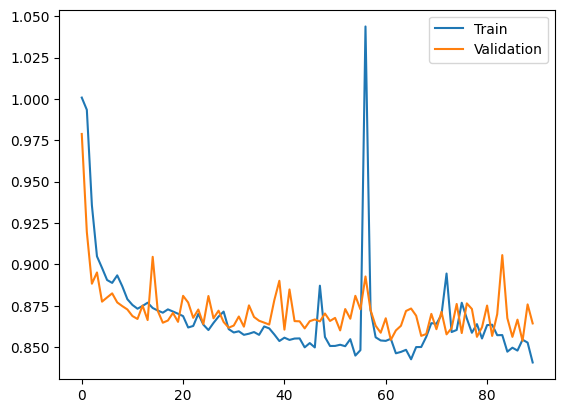

In [44]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [46]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))

In [47]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)

In [48]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.810	Test RMSE: 0.849


In [49]:
print(torch.mean(( y_train_t - y_pred_train )**2).item(),
torch.mean(( y_validation_t - y_pred_validation )**2).item(),
torch.mean(( y_test_t - y_pred_test )**2).item()
)

0.8101108074188232 0.8643036484718323 0.8492966294288635


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [52]:
model = model.cpu()
with torch.no_grad():
    # Move model to CPU and make predictions on training data
    y_pred_train = model(X_train_t.cpu()).numpy()
    y_pred_train = y_pred_train

    # Make predictions on test data
    y_pred_test = model(X_test_t.cpu()).numpy()
    y_pred_test = y_pred_test

# Convert tensors to numpy arrays for sklearn metrics
y_train_np = y_train_t.cpu().detach().numpy()
y_test_np = y_test_t.cpu().detach().numpy()

# MSE
train_mse = mean_squared_error(y_train_np, y_pred_train)
test_mse = mean_squared_error(y_test_np, y_pred_test)

# MAE
train_mae = mean_absolute_error(y_train_np, y_pred_train)
test_mae = mean_absolute_error(y_test_np, y_pred_test)

# R^2
train_r2 = r2_score(y_train_np, y_pred_train)
test_r2 = r2_score(y_test_np, y_pred_test)

# MAPE (Mean Absolute Percentage Error)
train_mape = np.mean(np.abs((y_train_np - y_pred_train) / y_train_np)) * 100
test_mape = np.mean(np.abs((y_test_np - y_pred_test) / y_test_np)) * 100

# Printing the metrics
# print("Train RMSE: %0.3F\tTest RMSE: %0.3F" % (train_rmse, test_rmse))
print("Train MSE: %0.3F\tTest MSE: %0.3F" % (train_mse, test_mse))
print("Train MAE: %0.3F\tTest MAE: %0.3F" % (train_mae, test_mae))
print("Train R^2: %0.3F\tTest R^2: %0.3F" % (train_r2, test_r2))
print("Train MAPE: %0.3F%%\tTest MAPE: %0.3F%%" % (train_mape, test_mape))Train MSE: 0.810	Test MSE: 0.849
Train MAE: 0.664	Test MAE: 0.683
Train R^2: 0.190	Test R^2: 0.140
Train MAPE: 288.032%	Test MAPE: 199.949%


Train MSE: 0.810	Test MSE: 0.849
Train MAE: 0.664	Test MAE: 0.683
Train R^2: 0.190	Test R^2: 0.140
Train MAPE: 288.032%	Test MAPE: 199.949%


In [87]:
y_pred_train.shape

(21090, 1)

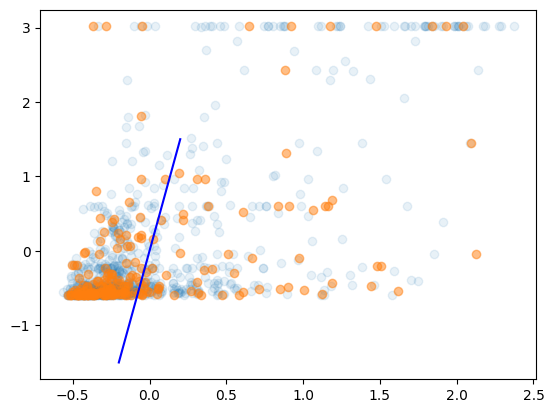

In [43]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-0.2, 0.2], [-1.5,1.5], c="b")
#plt.xlim(-1,  1)
#plt.ylim(-0.1,  1)